In [1]:
from storeSalesUtils.dataloading import load_stores, load_train, load_holidays, load_test, load_oil, DATA_FOLDER
from storeSalesUtils.plotting import plot_joint_plot
from storeSalesUtils.regressorPipeline import regressorPipeline, RMSLE, make_model_df

import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb

from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train = load_train()
test = load_test()

In [43]:
prediction_df = []
val_errors = []

count = 0

tqdm.pandas()
for idx, storeFamily_daily in tqdm(train.groupby(['store_nbr', 'family'])):
    store_nbr, family = idx
    
    # setup last year sales to use as a predictor
    storeFamily_daily['ly_sales'] = train.sales.shift(52*7)

    # only use two years of data available
    maxDate = storeFamily_daily.date.max()
    minDate = maxDate - pd.DateOffset(years=2)
    # print('Using data within the dates: ', minDate, maxDate)
    storeFamily_daily = storeFamily_daily[storeFamily_daily.date.between(minDate, maxDate)]

    # simulate test set scenario using the last 15 days of data for validation
    val_dates = maxDate - pd.DateOffset(15)
    storeFamily_daily['split'] = np.where(storeFamily_daily.date>=val_dates, 'validation', 'train')
    
    # setup pipeline values
    model = xgb.XGBRegressor(tree_method="hist", enable_categorical=True, n_jobs=6)
    category_cols = None
    group_col = 'store_nbr'
    backshift_cols = ['sales', 'ly_sales']
    ar_maxlags = 7
    ar_minlags = 1

    model_pipeline = regressorPipeline(model, storeFamily_daily, group_col, backshift_cols, ar_minlags, ar_maxlags, category_cols, filter=True)
    
    # make forecasts
    storeFamily_daily_test = test[(test.family==family) & (test.store_nbr==store_nbr)]
    test_forecast = model_pipeline.predict_test(storeFamily_daily_test)
    
    prediction_df.append(test_forecast)
    
    val_errors.append([store_nbr, family, model_pipeline.RMSLE_validation])

prediction_df = pd.concat(prediction_df)
print(prediction_df.shape)
prediction_df.head()

  0%|          | 0/1782 [00:00<?, ?it/s]

/home/jeronimo/miniconda3/envs/jero/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/jeronimo/Desktop/Freshflow_techChallenge/store_sales_forecasting/storeSalesUtils/storeSalesUtils/regressorPipeline.py:119: UserWarning: Ignoring feature selector step because number of selected features for Store 1.0, BABY CARE was zero.
  warnings.warn(f'Ignoring feature selector step because number of selected features for Store {store_nbr}, {family} was zero.')
/home/jeronimo/miniconda3/envs/jero/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

(1329372, 30)


,id,store_nbr,family,sales,onpromotion,ly_sales,split,date,sales_1,sales_2,...,ly_sales_6,ly_sales_7,year,month,day,dayofyear,dayofweek,weekofyear,is_weekend,pred
0,1700028.0,1.0,AUTOMOTIVE,3.0,0.0,NaN,train,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.619116
1,1701810.0,1.0,AUTOMOTIVE,1.0,0.0,NaN,train,NaT,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.619116
2,1703592.0,1.0,AUTOMOTIVE,0.0,0.0,NaN,train,NaT,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.619116
3,1705374.0,1.0,AUTOMOTIVE,10.0,0.0,NaN,train,NaT,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.619116
4,1707156.0,1.0,AUTOMOTIVE,4.0,0.0,NaN,train,NaT,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.619116


In [60]:
RMSLE(prediction_df.sales, prediction_df.pred)

0.796

In [56]:
# Store our predictions dataframe
pred_file = os.path.join(DATA_FOLDER, 'predictions/XGBoostBase_medianFilter.csv')
formatted_pred = prediction_df[prediction_df.split.isnull()][['id', 'pred']]
formatted_pred.columns = ['id', 'sales']
formatted_pred['id'] = formatted_pred.id.astype(int)
assert len(formatted_pred)==28512

formatted_pred.to_csv(path_or_buf=pred_file, index=False)
# formatted_pred.head()

In [46]:
val_errors = pd.DataFrame(val_errors, columns=['store_nbr', 'family', 'RMSLE_val'])
val_errors = val_errors.sort_values('RMSLE_val', ascending=False)

file = os.path.join(DATA_FOLDER, 'predictions/XGBoostBase_medianFilter_validationErrors.csv')
val_errors.to_csv(path_or_buf=file, index=False)

val_errors.head(20)

,store_nbr,family,RMSLE_val
691,21,SCHOOL AND OFFICE SUPPLIES,3.934
1747,53,SCHOOL AND OFFICE SUPPLIES,3.861
526,16,SCHOOL AND OFFICE SUPPLIES,3.153
1021,31,SCHOOL AND OFFICE SUPPLIES,3.143
1186,36,SCHOOL AND OFFICE SUPPLIES,3.052
163,5,SCHOOL AND OFFICE SUPPLIES,3.038
1628,50,FROZEN FOODS,2.913
1318,40,SCHOOL AND OFFICE SUPPLIES,2.869
1714,52,SCHOOL AND OFFICE SUPPLIES,2.809
477,15,HOME AND KITCHEN I,2.735


# Error analysis

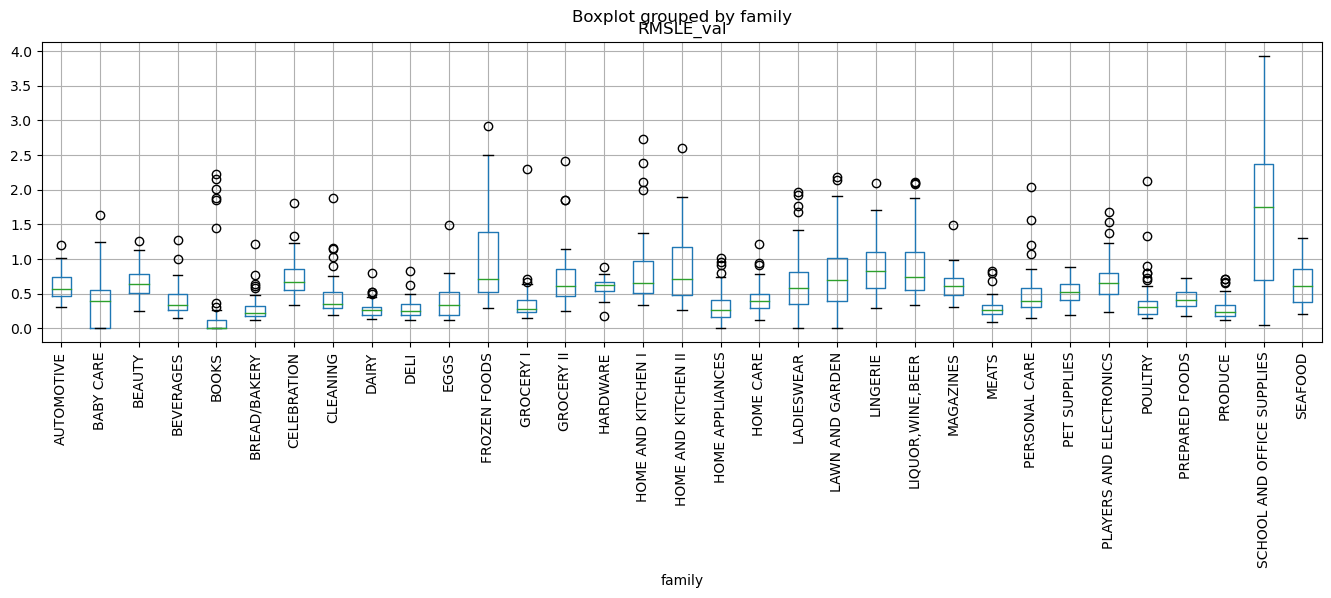

In [47]:
val_errors.boxplot(column='RMSLE_val', by='family')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot: >

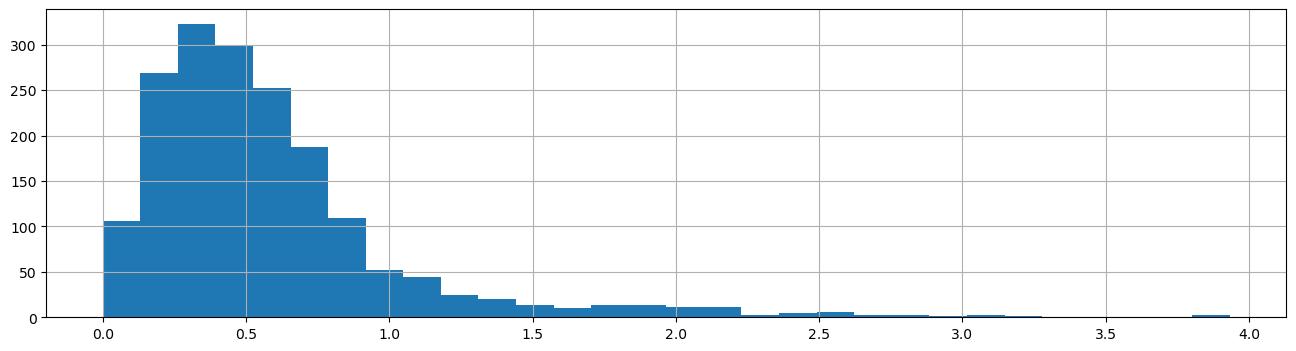

In [13]:
val_errors.RMSLE_val.hist(bins=30)

## Error by store

In [17]:
store_nbr, family = 21, 'SCHOOL AND OFFICE SUPPLIES'
# store_nbr, family = 9, 'SCHOOL AND OFFICE SUPPLIES'
# store_nbr, family = 50, 'SCHOOL AND OFFICE SUPPLIES'
# store_nbr, family = 39, 'MEATS'
# store_nbr, family = 48, 'FROZEN FOODS'
# store_nbr, family = 25, 'FROZEN FOODS'
# store_nbr, family = 1, 'FROZEN FOODS'
# store_nbr, family = 49, 'HOME AND KITCHEN I'

storeFamily_daily = train[(train.store_nbr==store_nbr) & (train.family==family)]

# setup last year sales to use as a predictor
storeFamily_daily['ly_sales'] = train.sales.shift(52*7)

# only use two years of data available
maxDate = storeFamily_daily.date.max()
minDate = maxDate - pd.DateOffset(years=2)
# print('Using data within the dates: ', minDate, maxDate)
storeFamily_daily = storeFamily_daily[storeFamily_daily.date.between(minDate, maxDate)]

# simulate test set scenario using the last 15 days of data for validation
val_dates = maxDate - pd.DateOffset(15)
storeFamily_daily['split'] = np.where(storeFamily_daily.date>=val_dates, 'validation', 'train')

# setup pipeline values
model = xgb.XGBRegressor(tree_method="hist", enable_categorical=True, n_jobs=6)
category_cols = None
group_col = 'store_nbr'
backshift_cols = ['sales', 'ly_sales']
ar_maxlags = 7
ar_minlags = 1

model_pipeline = regressorPipeline(model, storeFamily_daily, group_col, backshift_cols, ar_minlags, ar_maxlags, category_cols, filter=True)

# make forecasts
storeFamily_daily_test = test[(test.family==family) & (test.store_nbr==store_nbr)]
test_forecast = model_pipeline.predict_test(storeFamily_daily_test)

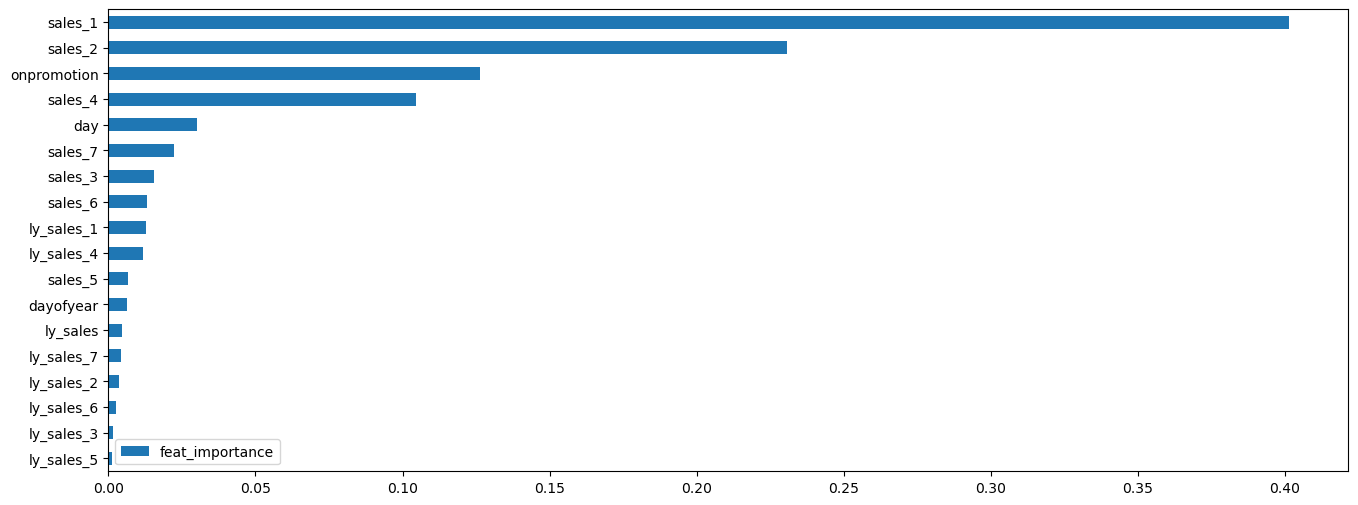

In [18]:
model_pipeline.plot_feature_importances()
plt.show()

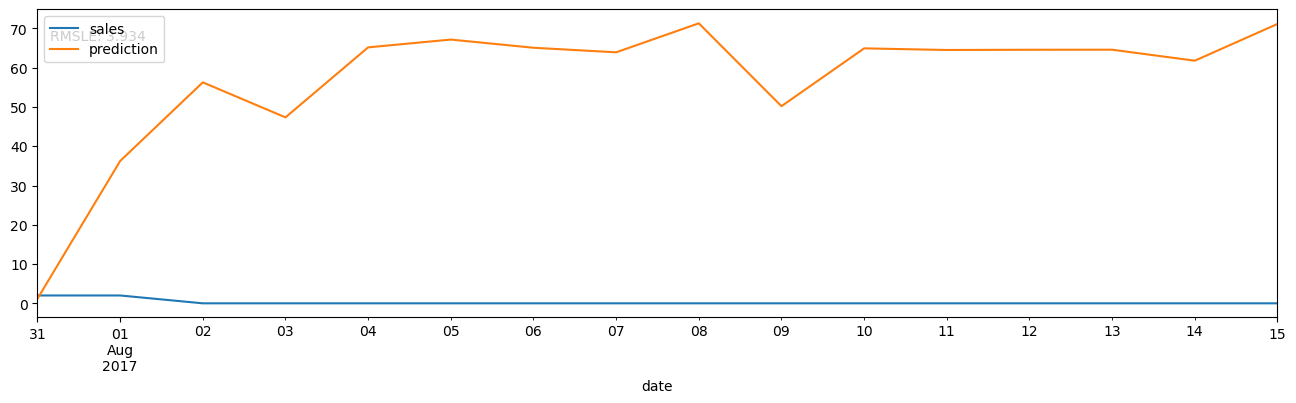

In [19]:
_store_df = model_pipeline.val_df
ax = _store_df.set_index('date').plot(y=['sales', 'prediction'])
plt.text(0.01, 0.9, "RMSLE: %.03f" %RMSLE(_store_df.sales, _store_df.prediction), transform=ax.transAxes)
plt.show()